## Import

### Import modules

In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas
import timeit #more accurate than time

import theano

from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import binned_statistic_2d

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.layers import Dense, Activation
from keras.models import Sequential, model_from_json, load_model

import seaborn as sns
sns.set_style("white")
import os
import json

from six.moves import cPickle #Faster than pickle

import sys
sys.path.append('../modules/')
from MPPlot import *
from Processors import *

Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


In [2]:
import importlib

def set_keras_backend(backend):
    """
    Changes Keras backend
    
    Parameters
    ----------
    backend : str
              Backend wanted (theano or tensorflow)
              
    Returns
    -------
    """
    
    idm = {"theano": "th", "tensorflow": "tf"}
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
        keras.backend.set_image_dim_ordering(idm[backend])

set_keras_backend("theano")

## Import dataTrain

In [3]:
loc = "../data/"
dataTrain = pandas.read_csv(loc + "DS_2_train.csv")
dataTest = pandas.read_csv(loc + "DS_2_test.csv")
sigdataTrain = dataTrain.signal == 1.0
bkgdataTrain = dataTrain.signal == 0.0
print("Train Sample contains {} signal events and {} background events, {} events total".format(
        len(dataTrain[sigdataTrain]), len(dataTrain[bkgdataTrain]), len(dataTrain)))
print("Test sample contains {} events total".format(len(dataTest)))

Train Sample contains 162209 signal events and 9649400 background events, 9811609 events total
Test sample contains 9789204 events total


In [4]:
dataTrain.head()

,index,event_id,X,Y,Z,TX,TY,chi2,signal,brick_number
0,0,35130,50550.007812,66924.796875,65943.0,0.639179,-0.086816,0.583319,1.0,53
1,1,-999,48811.390625,65584.648438,12930.0,0.569996,0.294196,1.582101,0.0,49
2,2,-999,30120.525391,28329.425781,21981.0,-0.366648,-0.379520,1.292502,0.0,39
3,3,-999,67186.773438,23033.931641,68529.0,-0.434561,0.502130,2.832125,0.0,65
4,4,-999,64832.343750,64279.328125,7758.0,0.139993,-0.417299,2.959314,0.0,13


### Feature sets

In [5]:
trainFeatures = ['X', 'Y', 'Z', 'TX', 'TY', 'chi2']

In [6]:
set0 = ['X', 'Y', 'Z', 'TX', 'TY', 'chi2']

In [8]:
classTrainFeatures = set0 #The features used
varSet = "set0" #Name of the feature set used, mainly for saving results
normIn = True #Whether we want to normalise and standardise the inputs
pca = True #Whether we want to use principal-component analysis to decorrelate inputs
normPCA = True #Whether we want to normalise and standardise the inputs after PCA
whiten = False #Whether we want to whiten input dataTrain
print("Training on {} features {}". format(len(classTrainFeatures),[var for var in classTrainFeatures]))

Training on 6 features ['X', 'Y', 'Z', 'TX', 'TY', 'chi2']


## Plot Initial Distributions

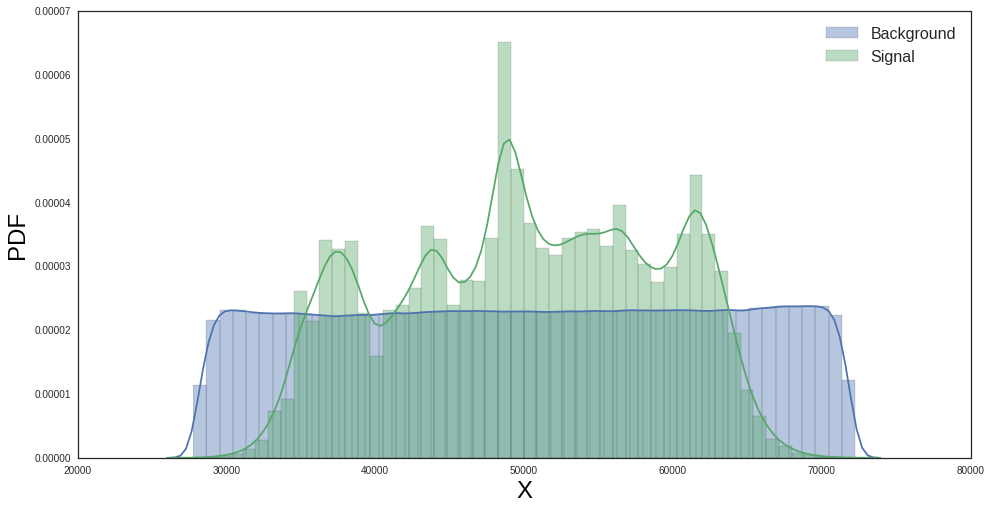

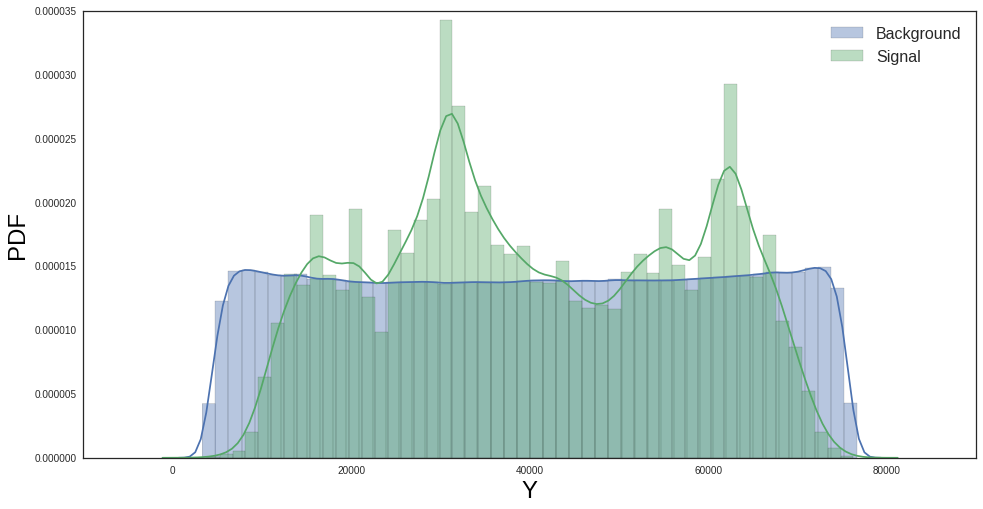

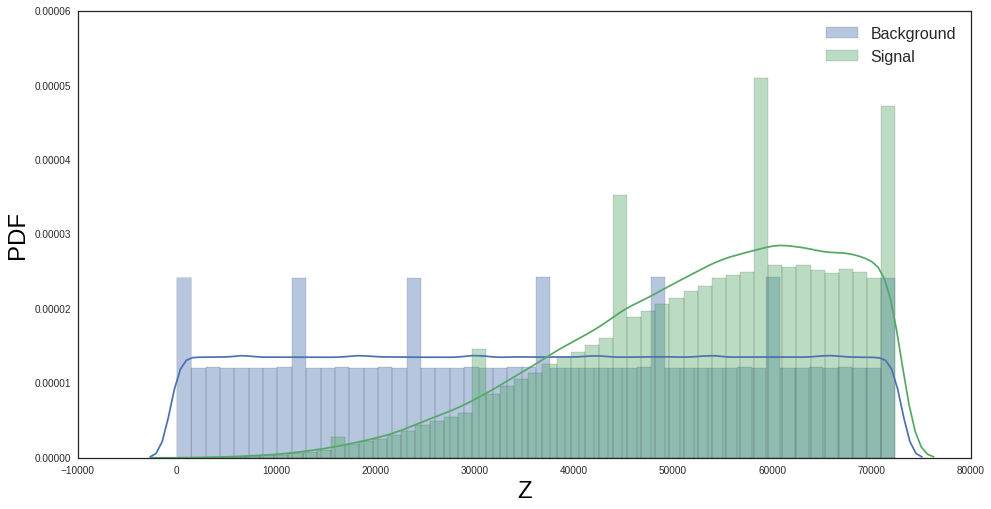

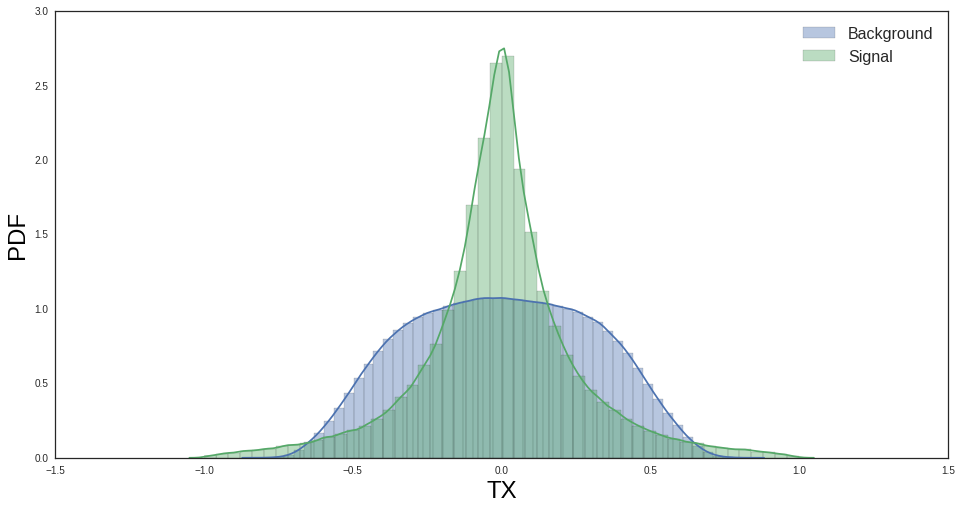

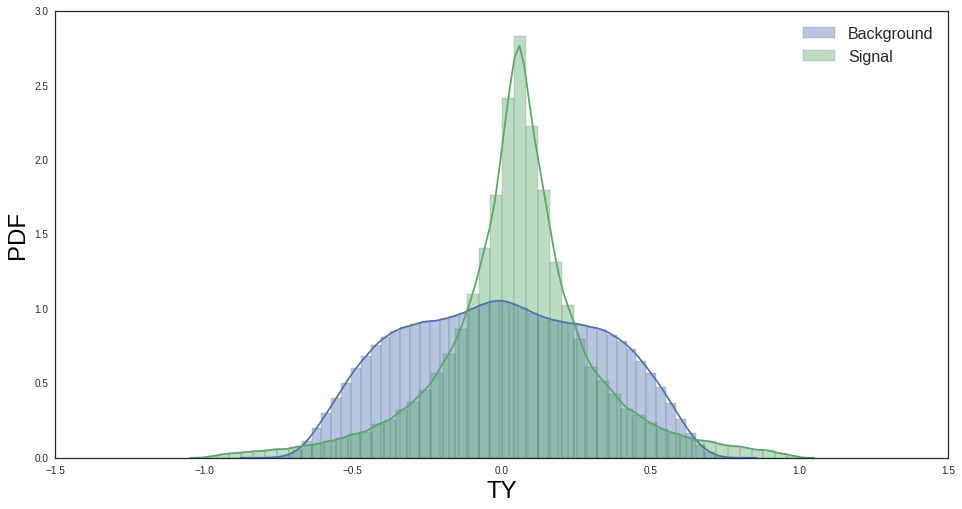

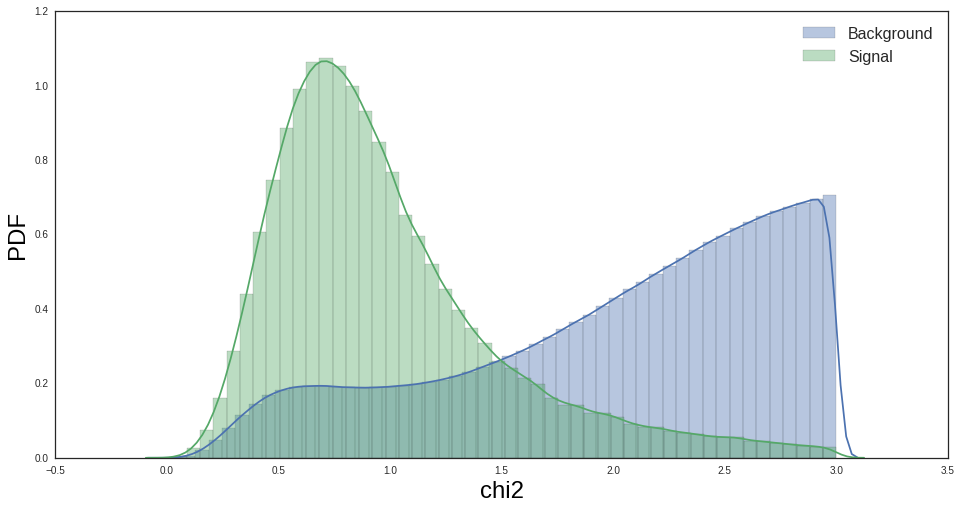

In [9]:
params = {'hist' : True, 'kde' : True, 'norm_hist' : True}
for feat in trainFeatures:
    plt.figure(figsize=(16, 8))
    sns.distplot(dataTrain[bkgdataTrain][feat], label='Background', **params)
    sns.distplot(dataTrain[sigdataTrain][feat], label='Signal', **params)
    plt.legend(loc='best', fontsize=16)
    plt.xlabel(feat, fontsize=24, color='black')
    plt.ylabel("PDF", fontsize=24, color='black')
    #plt.yscale('log', nonposy='clip')
    plt.show()

## Pre-process dataTrain

Here we define a SK-Learn pipeline which will contain transformation steps for any dataTrain fed in. Pipelines are a nice, compact way of handing dataTrain transformations.

In [10]:
stepsIn = []
if not normIn and not pca:
    stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
else:
    if normIn:
        stepsIn.append(('normIn', StandardScaler()))
    if pca:
        stepsIn.append(('pca', PCA(whiten=whiten)))
        if normPCA:
            stepsIn.append(('normPCA', StandardScaler()))
inputPipe = Pipeline(stepsIn)
stepsOut = []

Next we fit the pipeline to the **development** dataTrain inputs. For compactness we also transform the development dataTrain and create Numpy arrays of the inputs and targets. **N.B.** The type of the inputs will normally be either float32 or float64. float32 is preferred, since speed and memory outweighs precision. Sometimes if the dataTrain is naturally in float64, the conversion to float32 can can result in NaNs or infs, so watch out.

In [11]:
inputPipe.fit(dataTrain[sigdataTrain][classTrainFeatures].values.astype('float32'))
signal = inputPipe.transform(dataTrain[sigdataTrain][classTrainFeatures].values.astype('float32'))
background = inputPipe.transform(dataTrain[bkgdataTrain][classTrainFeatures].values.astype('float32'))

## Plot pre-processed Distributions

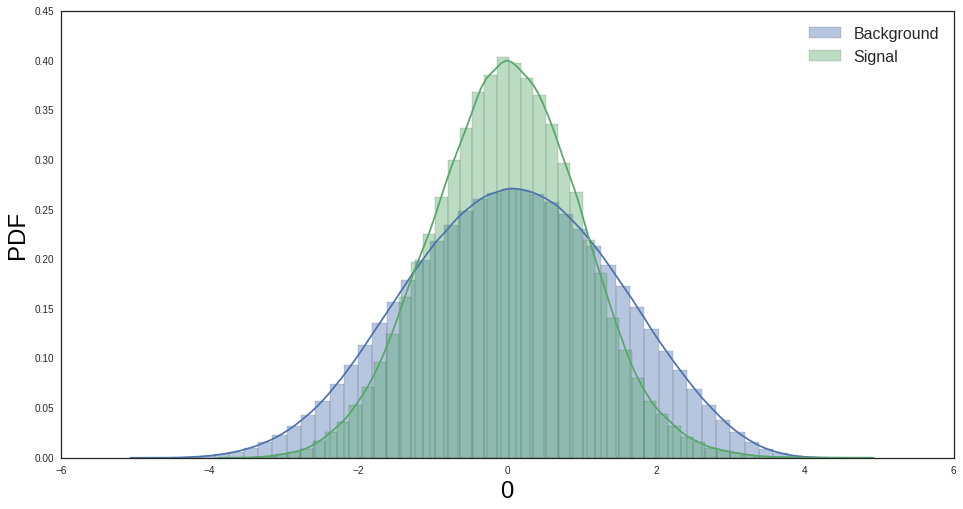

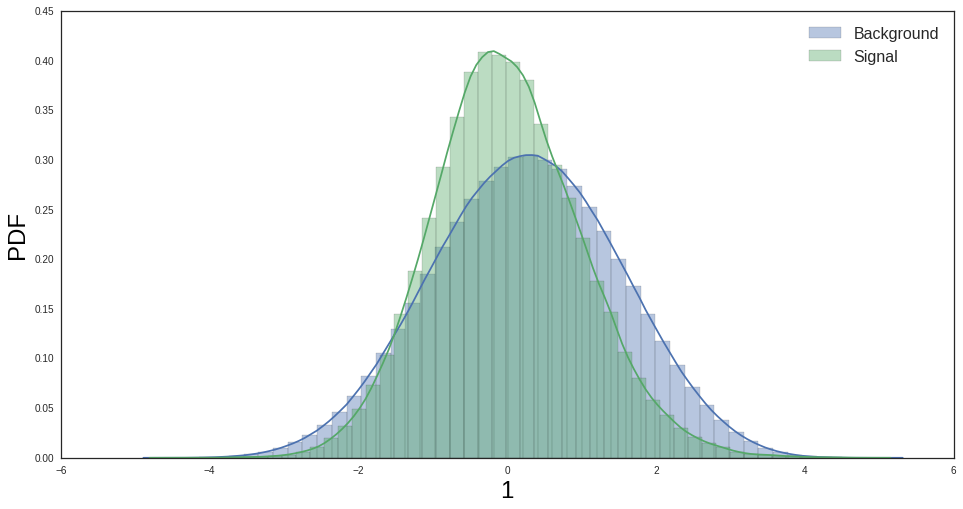

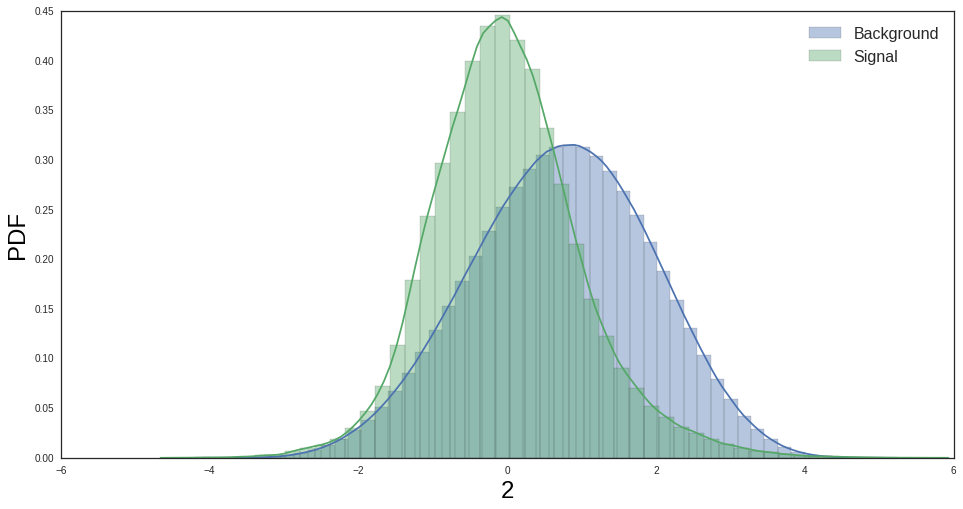

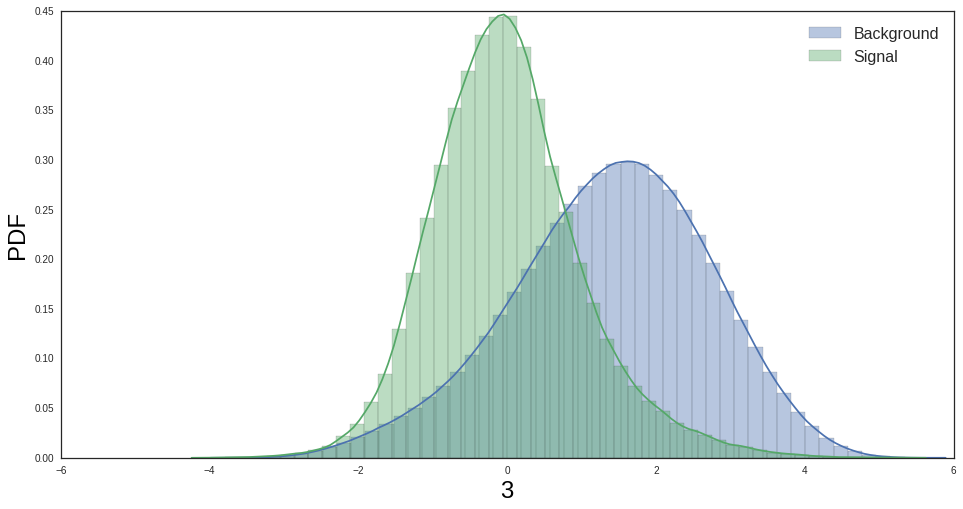

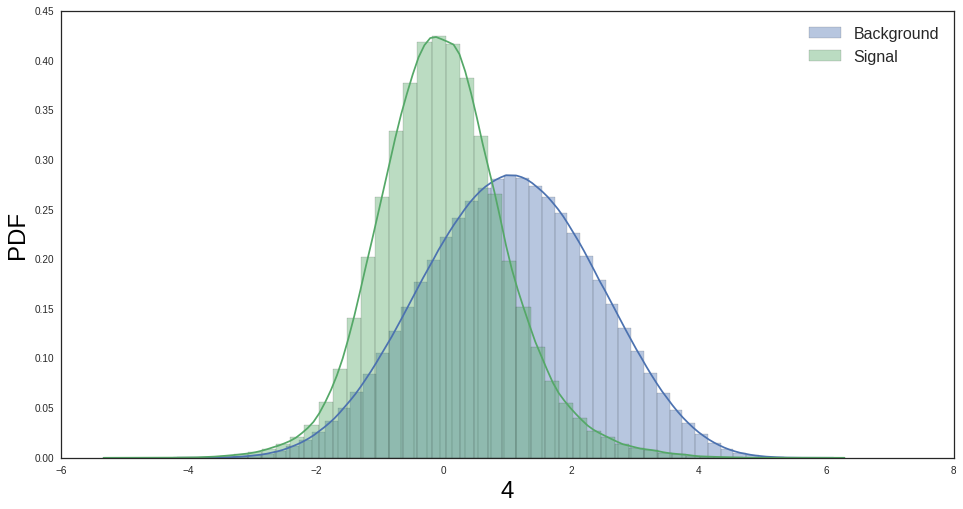

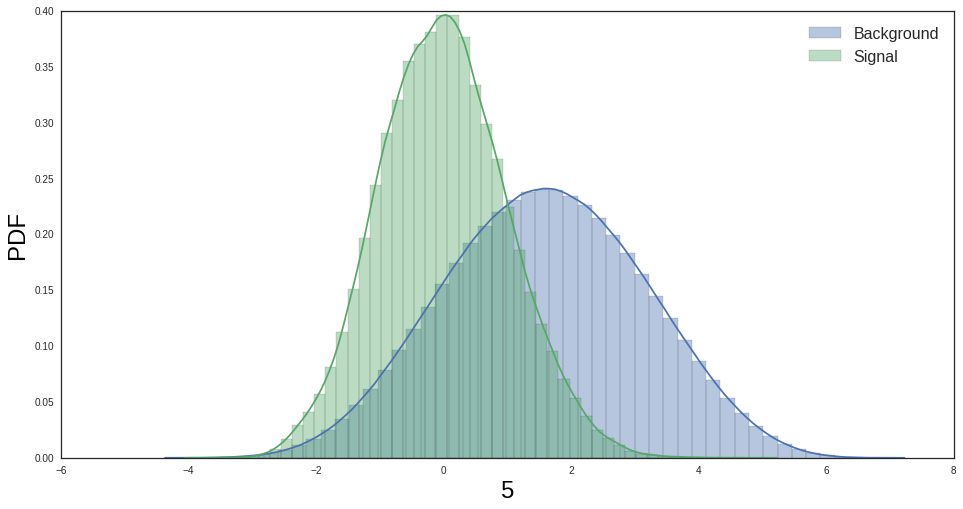

In [12]:
params = {'hist' : True, 'kde' : True, 'norm_hist' : True}
for i in range(len(signal[0])):
    plt.figure(figsize=(16, 8))
    sns.distplot(background[:,i], label='Background', **params)
    sns.distplot(signal[:,i], label='Signal', **params)
    plt.legend(loc='best', fontsize=16)
    plt.xlabel(i, fontsize=24, color='black')
    plt.ylabel("PDF", fontsize=24, color='black')
    plt.show()

## Compare Train to Test

### Initial

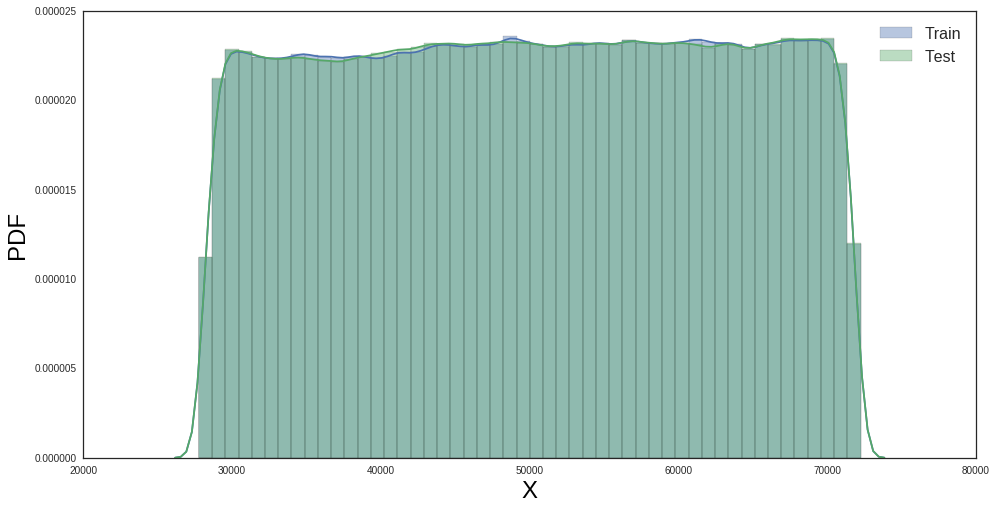

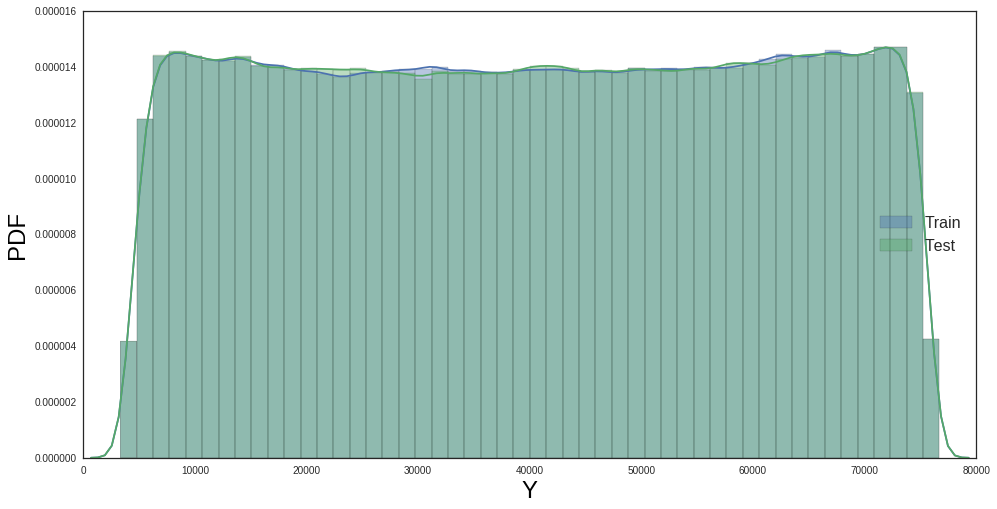

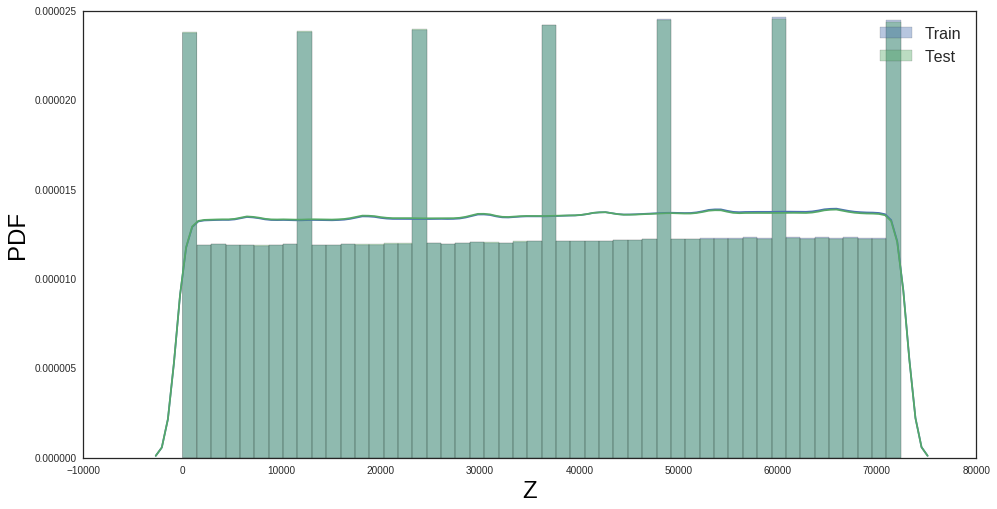

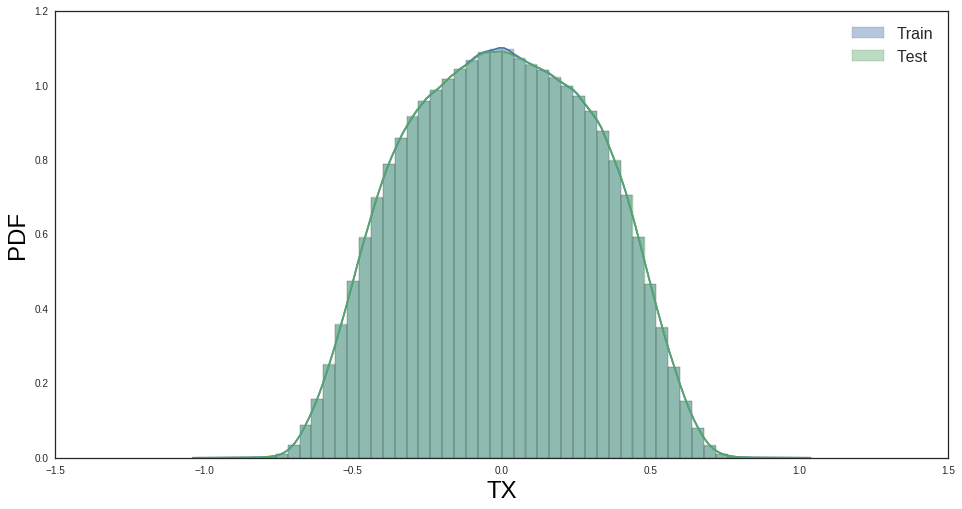

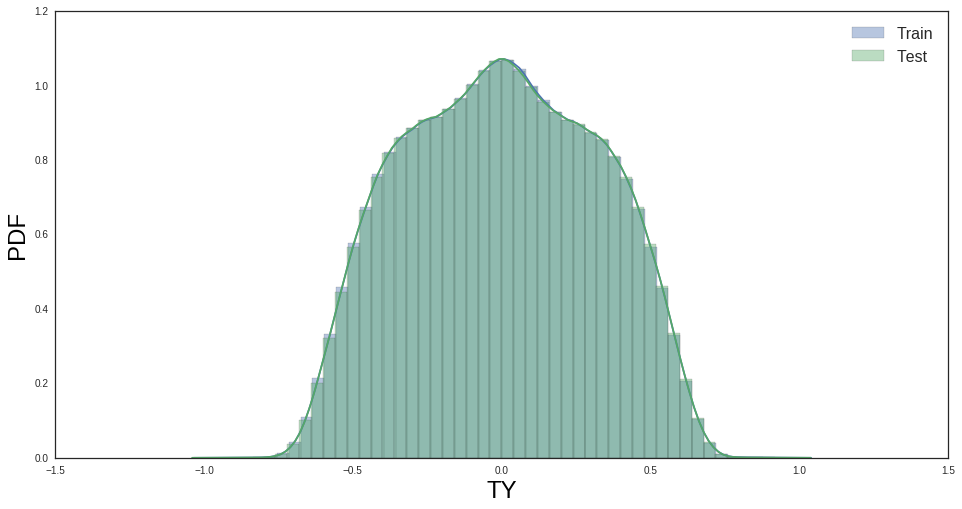

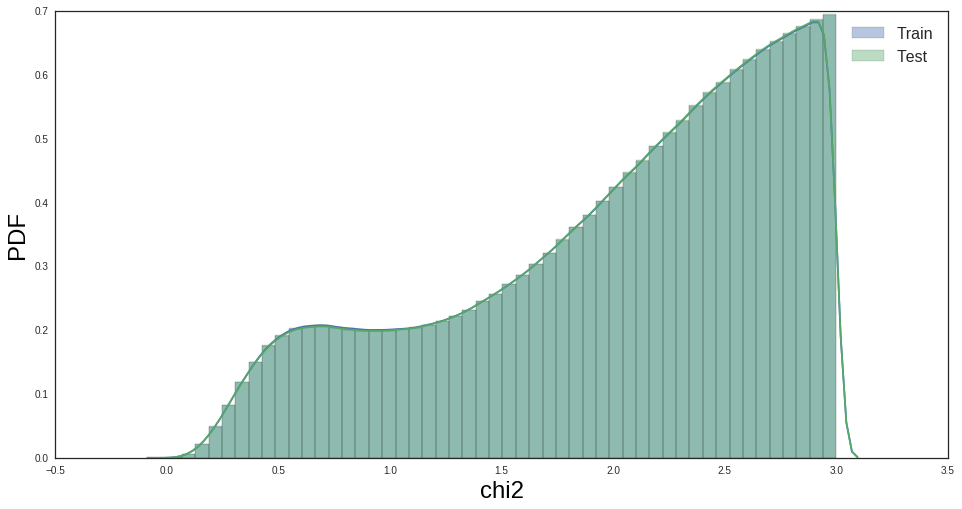

In [13]:
params = {'hist' : True, 'kde' : True, 'norm_hist' : True}
for feat in trainFeatures:
    plt.figure(figsize=(16, 8))
    sns.distplot(dataTrain[feat], label='Train', **params)
    sns.distplot(dataTest[feat], label='Test', **params)
    plt.legend(loc='best', fontsize=16)
    plt.xlabel(feat, fontsize=24, color='black')
    plt.ylabel("PDF", fontsize=24, color='black')
    plt.show()

### Pre-processed

In [ ]:
train = inputPipe.transform(dataTrain[classTrainFeatures].values.astype('float32'))
test = inputPipe.transform(dataTest[classTrainFeatures].values.astype('float32'))

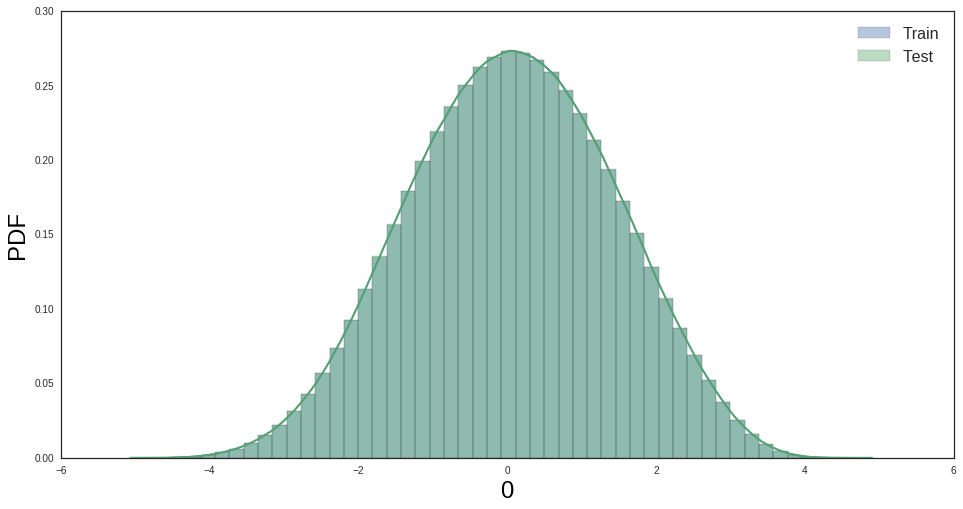

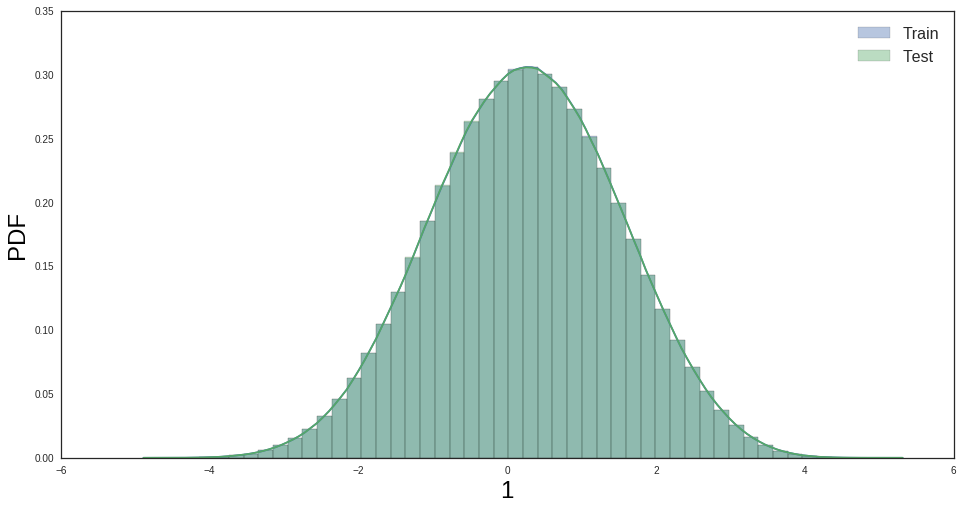

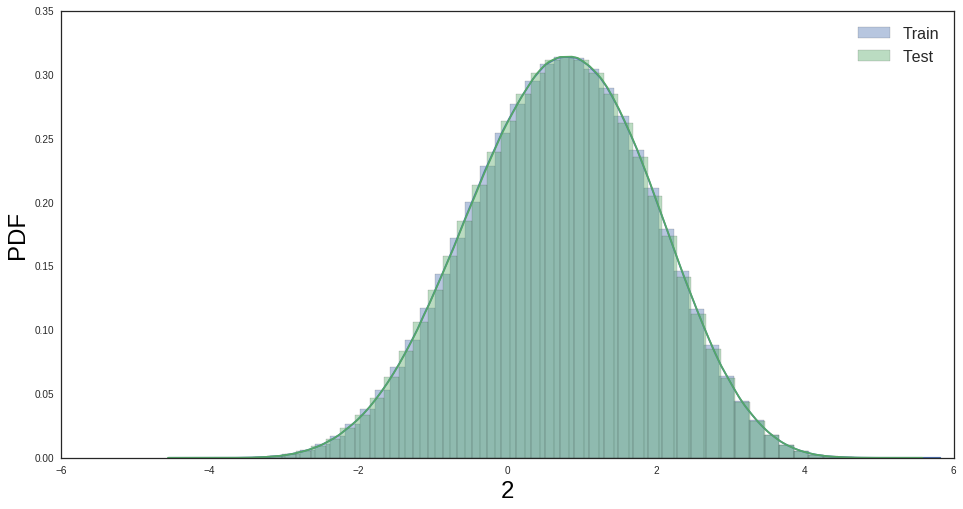

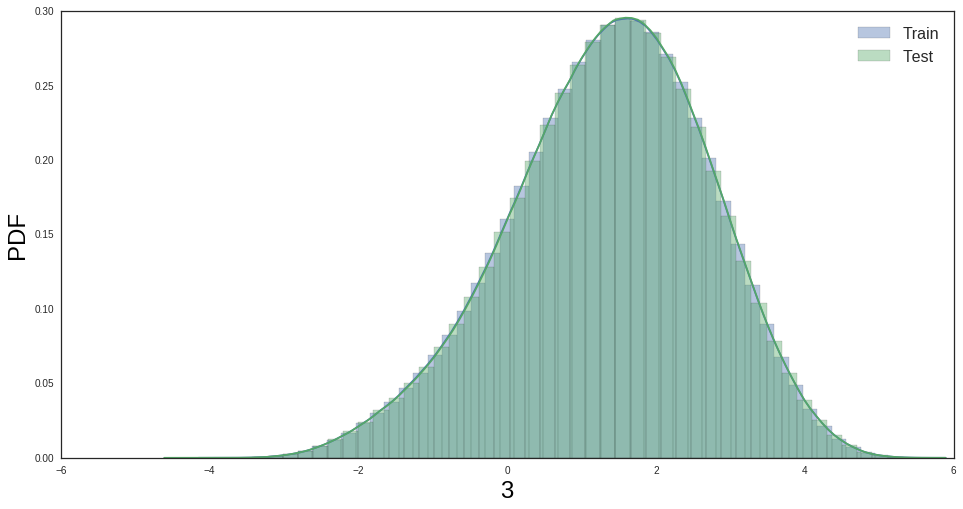

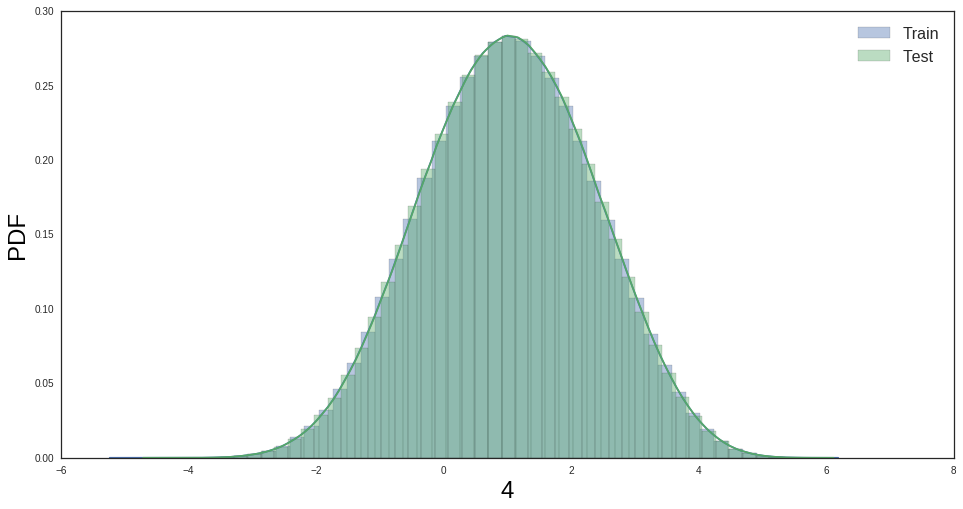

In [ ]:
params = {'hist' : True, 'kde' : True, 'norm_hist' : True}
for i in range(len(signal[0])):
    plt.figure(figsize=(16, 8))
    sns.distplot(train[:,i], label='Train', **params)
    sns.distplot(test[:,i], label='Test', **params)
    plt.legend(loc='best', fontsize=16)
    plt.xlabel(i, fontsize=24, color='black')
    plt.ylabel("PDF", fontsize=24, color='black')
    plt.show()

## Reweight test

In [ ]:
signalXY = binned_statistic_2d(dataTrain.ix[sigdataTrain, 'X'].values,
                                  dataTrain.ix[sigdataTrain, 'Y'].values,
                                  dataTrain.ix[sigdataTrain, 'Y'].values,
                                  statistic='count', expand_binnumbers=True,
                                  range=((np.min(dataTrain.ix[:, 'X'].values),
                                          np.max(dataTrain.ix[:, 'X'].values)),
                                         (np.min(dataTrain.ix[:, 'Y'].values),
                                          np.max(dataTrain.ix[:, 'Y'].values))),
                                  bins=(50, 50))
bkgXY = binned_statistic_2d(dataTrain.ix[bkgdataTrain, 'X'].values,
                                  dataTrain.ix[bkgdataTrain, 'Y'].values,
                                  dataTrain.ix[bkgdataTrain, 'Y'].values,
                                  statistic='count', expand_binnumbers=True,
                                  range=((np.min(dataTrain.ix[:, 'X'].values),
                                          np.max(dataTrain.ix[:, 'X'].values)),
                                         (np.min(dataTrain.ix[:, 'Y'].values),
                                          np.max(dataTrain.ix[:, 'Y'].values))),
                                  bins=(50, 50))

In [ ]:
dataTrain.ix[sigdataTrain, 'weight'] = 1/signalXY.statistic[signalXY.binnumber[0]-1, signalXY.binnumber[1]-1]
dataTrain.ix[bkgdataTrain, 'weight'] = 1/bkgXY.statistic[bkgXY.binnumber[0]-1, bkgXY.binnumber[1]-1]
dataTrain.ix[sigdataTrain, 'weight'] = dataTrain.ix[sigdataTrain, 'weight']/np.sum(dataTrain.ix[sigdataTrain, 'weight'])
dataTrain.ix[bkgdataTrain, 'weight'] = dataTrain.ix[bkgdataTrain, 'weight']/np.sum(dataTrain.ix[bkgdataTrain, 'weight'])

In [ ]:
hist_params = {'normed': False, 'bins': (50,50), 'alpha': 1, 
               'range': ((np.min(dataTrain.ix[:, 'X'].values),
                                          np.max(dataTrain.ix[:, 'X'].values)),
                                         (np.min(dataTrain.ix[:, 'Y'].values),
                                          np.max(dataTrain.ix[:, 'Y'].values)))}
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.hist2d(dataTrain.ix[sigdataTrain,'X'].values, dataTrain.ix[sigdataTrain,'Y'].values,
           weights=np.ones_like(dataTrain.ix[sigdataTrain,'weight'].values)/len(dataTrain.ix[sigdataTrain]), **hist_params)
ax1.set_title("Unweighted Signal")
ax2.hist2d(dataTrain.ix[sigdataTrain,'X'].values, dataTrain.ix[sigdataTrain,'Y'].values,
           weights=dataTrain.ix[sigdataTrain,'weight'].values, **hist_params)
ax2.set_title("Weighted Signal")
ax3.hist2d(dataTrain.ix[bkgdataTrain,'X'].values, dataTrain.ix[bkgdataTrain,'Y'].values,
           weights=np.ones_like(dataTrain.ix[bkgdataTrain,'weight'].values)/len(dataTrain.ix[sigdataTrain]), **hist_params)
ax3.set_title("Unweighted Background")
ax4.hist2d(dataTrain.ix[bkgdataTrain,'X'].values, dataTrain.ix[bkgdataTrain,'Y'].values,
           weights=dataTrain.ix[bkgdataTrain,'weight'].values, **hist_params)
ax4.set_title("Weighted Background")
plt.show()